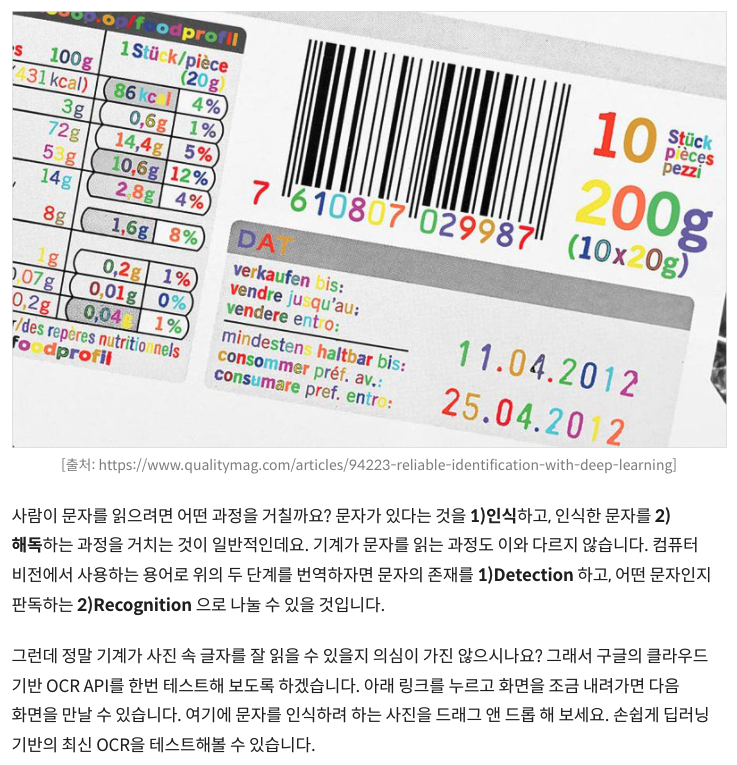

구글 OCR API : https://cloud.google.com/vision

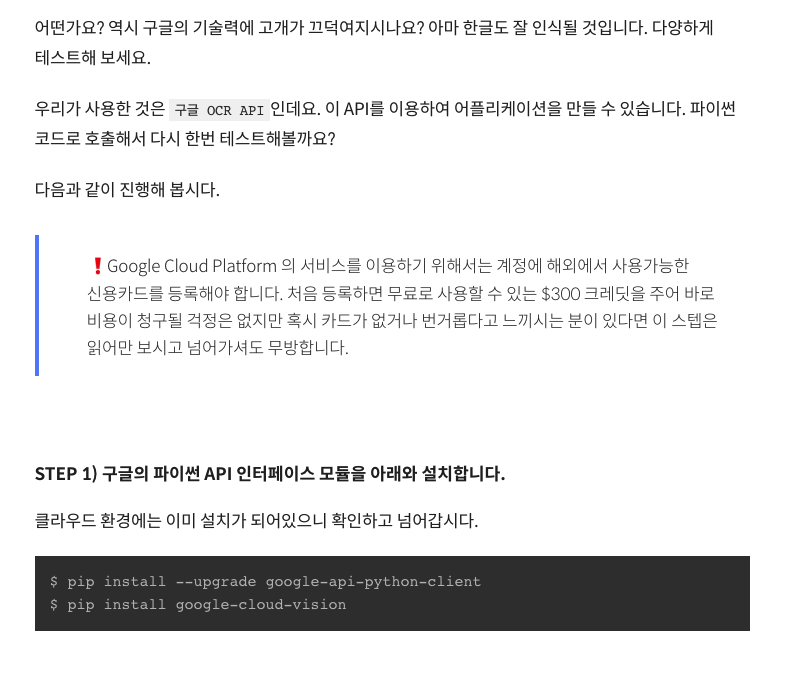

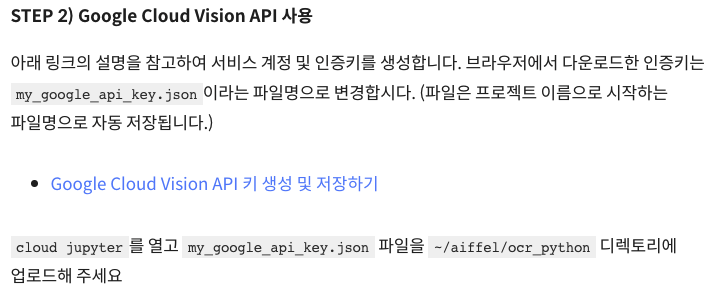

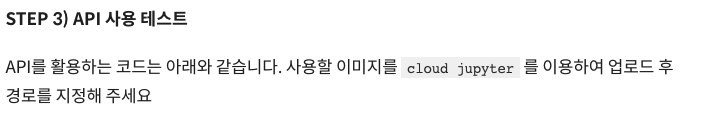

```
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

```

```
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다

!ls -l $GOOGLE_APPLICATION_CREDENTIALS
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = # [[YOUR IMAGE FILE PATH]]   
# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)
```

# OCR 접근방식

- 1. 네이버 이활석님 CRAFT 모델소개, 연구 경험 : https://tv.naver.com/v/4578167
- 2. Terry TaeWoong UM , OCR소개 : https://www.youtube.com/watch?v=ckRFBl_XWFg

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


만들어둔 파이프라인의 recognize()에 이미지를 넣는다.


이미지링크 : https://unsplash.com/s/photos/text

In [2]:
# 테스트에 사용할 이미지 url
image_urls = [
    'https://source.unsplash.com/M7mu6jXlcns/640x460',
    'https://source.unsplash.com/6jsp4iHc8hI/640x460',
    'https://source.unsplash.com/98uYQ-KupiE',
    'https://source.unsplash.com/j9JoYpaJH3A',
    'https://source.unsplash.com/eBkEJ9cH5b4'
]
image = [keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


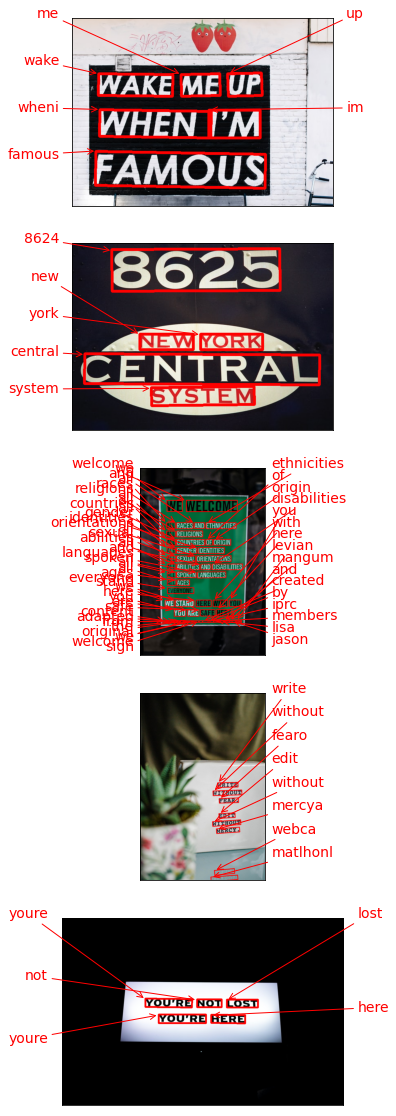

In [3]:
# 시각화
fig, axs = plt.subplots(nrows=len(image), figsize=(20,20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=image[idx], predictions=prediction_groups[idx][0], ax=ax)

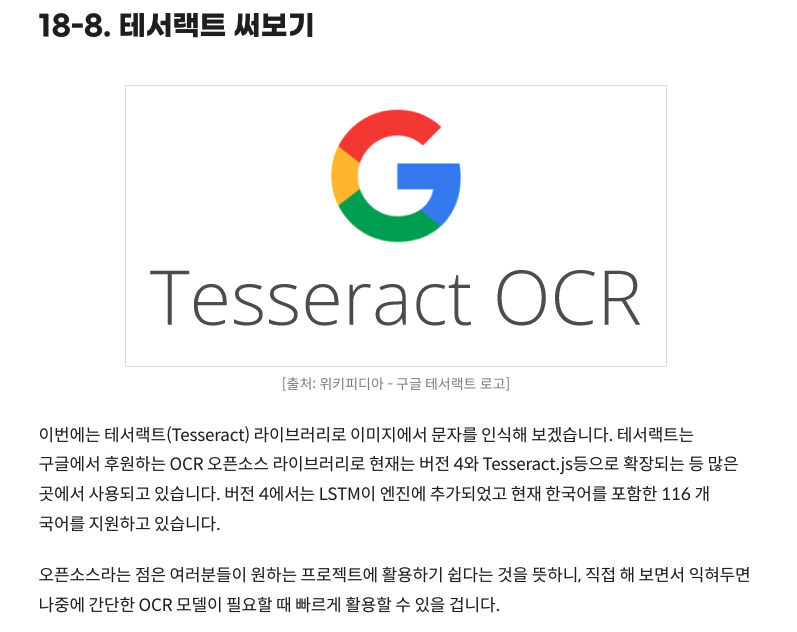

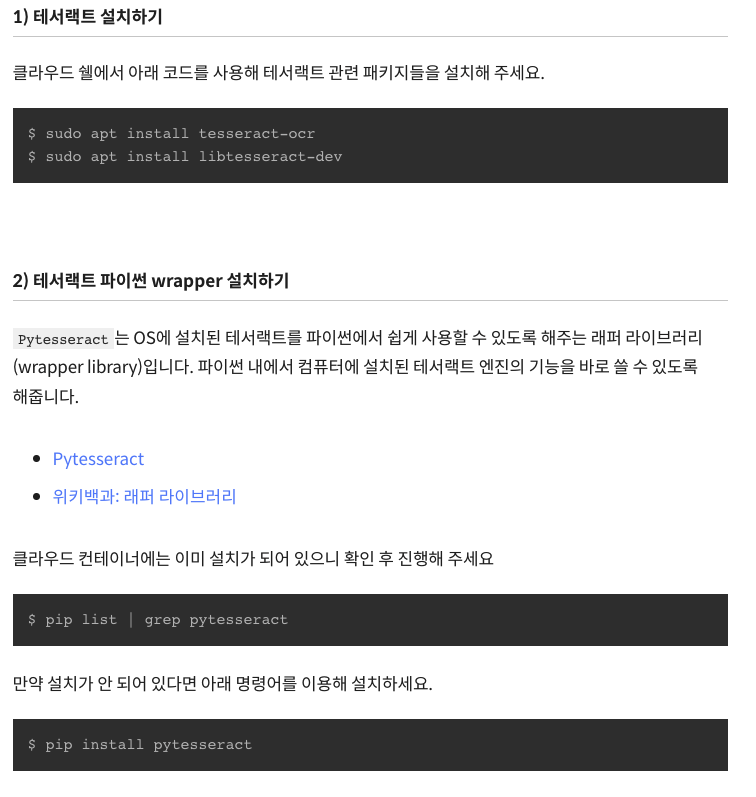

### 3. 태서랙트로 문자 검출하고 이미지 자르기(detection)

In [7]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.jpg', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.jpg")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.jpg
/aiffel/aiffel/ocr_python/0001.jpg
/aiffel/aiffel/ocr_python/0002.jpg
/aiffel/aiffel/ocr_python/0003.jpg
/aiffel/aiffel/ocr_python/0004.jpg
/aiffel/aiffel/ocr_python/0005.jpg
/aiffel/aiffel/ocr_python/0006.jpg
/aiffel/aiffel/ocr_python/0007.jpg
/aiffel/aiffel/ocr_python/0008.jpg
/aiffel/aiffel/ocr_python/0009.jpg
/aiffel/aiffel/ocr_python/0010.jpg
/aiffel/aiffel/ocr_python/0011.jpg
/aiffel/aiffel/ocr_python/0012.jpg
/aiffel/aiffel/ocr_python/0013.jpg
/aiffel/aiffel/ocr_python/0014.jpg
/aiffel/aiffel/ocr_python/0015.jpg
/aiffel/aiffel/ocr_python/0016.jpg
/aiffel/aiffel/ocr_python/0017.jpg
/aiffel/aiffel/ocr_python/0018.jpg
/aiffel/aiffel/ocr_python/0019.jpg


### 4. 태서렉트로 잘린 이미지에서 단어 인식

In [8]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(image,
                                                     lang='kor',
                                                     config = custom_oem_psm_config,
                                                     output_type = Output.DICT)
        print(recognized_data['text'])
    print('Done')
    
# 얻어진 text 출력
recognize_images(cropped_image_path_list)

뜨거운

사

랑이


있기에

부

나 27

「

가

능

하

다 그

본다.

^ 도.

에

너

지

들

내서


Done


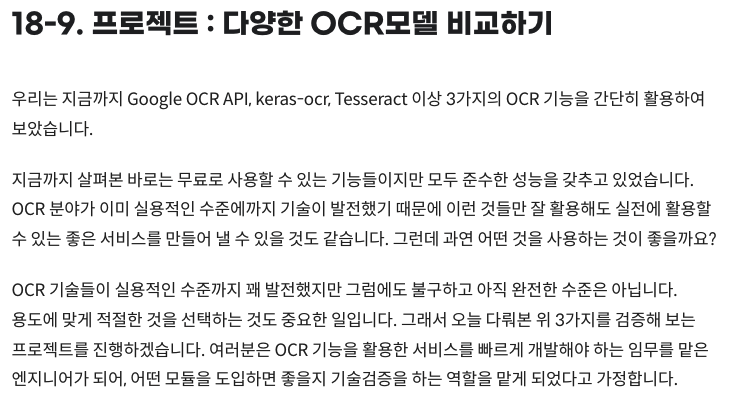

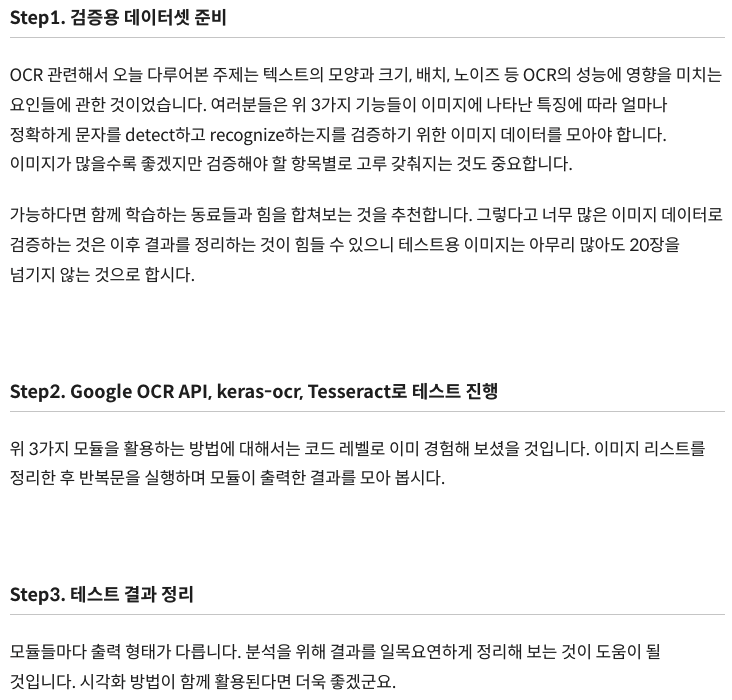

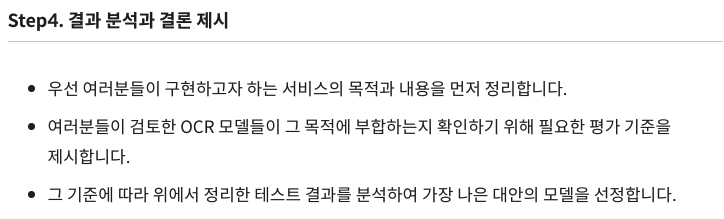